In [1]:
# Geodetic to Geocentric coordinates transformation
# WGS84 constants
# reference:
# http://earth-info.nga.mil/GandG/publications/tr8350.2/wgs84fin.pdf

import numpy as np
a_WGS=6378.137
flatness = 1./298.257223563  # flatenning
b_WGS=a_WGS*(1.-flatness)    # WGS polar radius (semi-minor axis) in km
eccentricity=np.sqrt(a_WGS**2-b_WGS**2)/a_WGS

def geod2geoc(lon,geodlat,h):
    # returns geocentric xyz coordinates (ECEF) in km of a target with
    # latitude       geodlat (rad) --- geodetic
    # longitude      lon (rad)
    # height         h (km above local ellipsoid)
    n=a_WGS / np.sqrt(1.-flatness*(2.-flatness) * np.sin(geodlat)**2.)
    # cartesian geocentric coordinates wrt Greenwich
    x=(n+h)*np.cos(geodlat)*np.cos(lon)
    y=(n+h)*np.cos(geodlat)*np.sin(lon)
    z=(n*(1.-eccentricity**2.)+h)*np.sin(geodlat)   
    
    p   = np.sqrt(x**2. + y**2.)
    geoclat = np.arctan2(z,p)        # geocentric latitude (theta)
    
    return x,y,z,geoclat

# Inclination and Declination maps on Feb19, 2021

In [2]:
%pylab inline
try:
    import cartopy
    usecartopy = True
except:
    print("Warning! Cartopy not installed. Proceeding without it.")
    usecartopy = False # Allow us to plot the maps even when cartopy is not installed
if usecartopy:
    print("cartopy has been detected and imported")

Populating the interactive namespace from numpy and matplotlib
cartopy has been detected and imported


In [3]:
from pyigrf import igrf
import datetime
import numpy as np
import time

t0 = time.time()
deg = 180/np.pi
dt0 = datetime.datetime(2021,2,19)
yeardays = datetime.datetime(dt0.year,12,31).timetuple().tm_yday
doy = dt0.timetuple().tm_yday
year = dt0.year + doy/yeardays

longs = np.arange(-179,179,1)
lats = np.arange(-89,89,1)
ht=0
inclination = np.empty((lats.size,longs.size),dtype = np.float64) * np.nan
declination = np.empty((lats.size,longs.size),dtype = np.float64) * np.nan
for i,geod_lat in enumerate(lats):
    for j,lon in enumerate(longs):
        x,y,z,theta = geod2geoc(lon/deg, geod_lat/deg, ht)
        [Bn,Be,Bd,B] = igrf.igrf_B(year, ht, lon, theta*deg)
        # Bn,Be,Bd are the geocentric n,e,d components. Bpz at the meridional plane:
        Bpz = Bn*np.array([-np.sin(theta), np.cos(theta)]) - Bd * np.array([np.cos(theta), np.sin(theta)])
        # Geodetic north and downward components:
        BN = np.dot(Bpz, np.array([-np.sin(geod_lat/deg), np.cos(geod_lat/deg)]) )
        BD = np.dot(Bpz, - np.array([np.cos(geod_lat/deg), np.sin(geod_lat/deg)]))
        inclination[i,j] = np.arcsin(BD/B)*deg
        declination[i,j] = np.arctan2(Be,BN)*deg

t1 = time.time()
print("Time elapsed calculating IGRF for %d points: %d seconds"%(inclination.size, t1-t0))

Time elapsed calculating IGRF for 63724 points: 12 seconds


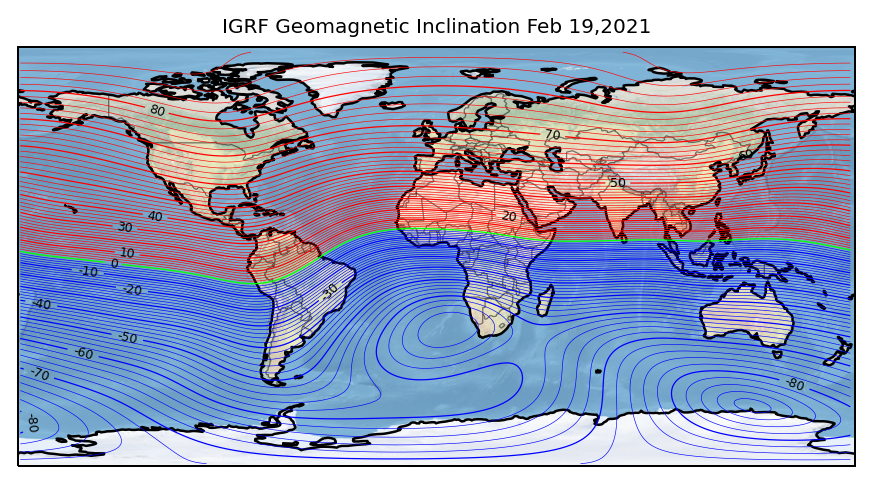

In [4]:
if usecartopy:
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    fig,ax = plt.subplots(dpi=180,subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cf.BORDERS, linestyle='-', alpha=.5, linewidth=0.5)
    ax.stock_img()
    ax.coastlines()
else:
    fig,ax = plt.subplots(dpi=180)

levels = np.arange(-90,90,2)
colors = ["red" if x>0 else ("blue" if x<0 else "lime") for x in levels]
linewidths = [0.5 if x%10==0 else 0.25 for x in levels]
CS = ax.contour(longs,lats,inclination, levels=levels, colors=colors, linewidths=linewidths, linestyles="-")
ax.clabel(CS,np.arange(-90,90,10), inline=1, fontsize=5,fmt="%g",colors='k')
ax.set_title(dt0.strftime("IGRF Geomagnetic Inclination %b %d,%Y"),fontsize=8);

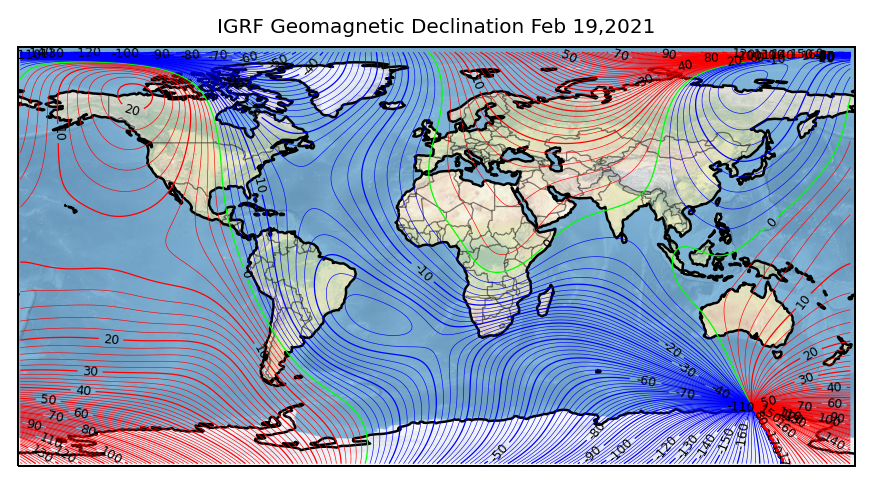

In [5]:
if usecartopy:
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    fig,ax = plt.subplots(dpi=180,subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_global()
    ax.add_feature(cf.BORDERS, linestyle='-', alpha=.5, linewidth=0.5)
    ax.stock_img()
    ax.coastlines()
else:
    fig,ax = plt.subplots(dpi=180)
levels = np.arange(-180,180,2)
colors = ["red" if x>0 else ("blue" if x<0 else "lime") for x in levels]
linewidths = [0.5 if x%10==0 else 0.25 for x in levels]
CS = ax.contour(longs,lats,declination, levels=levels, colors=colors, linewidths=linewidths, linestyles="-")
ax.clabel(CS,np.arange(-180,180,10), inline=1, fontsize=5,fmt="%g",colors='k')
ax.set_title(dt0.strftime("IGRF Geomagnetic Declination %b %d,%Y"),fontsize=8);